# 1) Importación de librerías

In [1]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.decomposition import PCA
from google.colab import drive
import numpy as np
from transformers import AutoModelForSequenceClassification
import matplotlib.pyplot as plt
import pickle
import re
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
from scipy.stats import norm




# 2) Carga del dataset

In [46]:
drive.mount('/content/drive/')
file_path = '/content/drive/My Drive/Colab Notebooks/LLM/IMDB_dataset.csv'
df = pd.read_csv(file_path, encoding='utf-8')
pd.set_option('display.width',30)
#df.head()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [47]:
#Verifico las dimensiones del dataset
df.shape

(50000, 2)

# 3) Preprocesamiento

In [48]:
# Función para limpiar el texto utilizando regex
def limpiar_texto(texto):
    # Utilizamos una expresión regular para eliminar puntos, guiones, comas y otros símbolos que no sean letras o números, así como también etiquetas HTML, incluyendo <br> y sus variantes
    texto_limpio = re.sub(r'<br\s*/?>', ' ', texto)
    texto_limpio = re.sub(r'[^\w\s]', '', texto_limpio)
    return texto_limpio

# Aplicamos la función de limpieza a la columna 'texto'
df['cleaned_review'] = df['review'].apply(limpiar_texto)


In [49]:
df_1 = df[['cleaned_review','sentiment']]

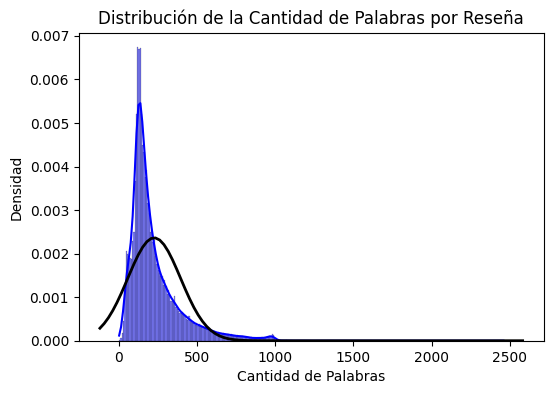

In [50]:
#Análisis de la longitud de secuencia de review en el dataset
df_1['word_count'] = df_1['cleaned_review'].apply(lambda x: len(x.split()))

# Calcular la media y el desvío estándar de la cantidad de palabras por reseña
mean_word_count = df_1['word_count'].mean()
std_word_count = df_1['word_count'].std()

# Visualizar la distribución de la cantidad de palabras por reseña
plt.figure(figsize=(6,4))
sns.histplot(df_1['word_count'], kde=True, stat='density', color='blue')
plt.title('Distribución de la Cantidad de Palabras por Reseña')
plt.xlabel('Cantidad de Palabras')
plt.ylabel('Densidad')
# Agregar la línea de distribución normal
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean_word_count, std_word_count)
plt.plot(x, p, 'k', linewidth=2)
plt.show()

In [51]:
max_word_count = df_1['word_count'].max()

# Imprimir la máxima longitud de reseña
print("Máxima longitud de reseña:", max_word_count)

Máxima longitud de reseña: 2459


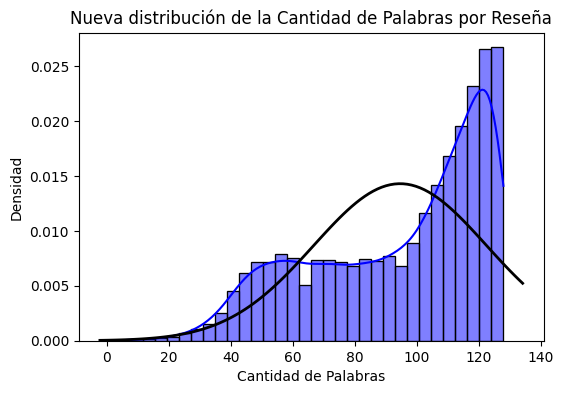

In [52]:
#Me quedo con las secuencias con una longitud menor o igual a la máxima aceptada por BERT (512)
df_2 = df_1[df_1['word_count'] < 129]

# Calcular la media y el desvío estándar de la cantidad de palabras por reseña
mean_word_count = df_2['word_count'].mean()
std_word_count = df_2['word_count'].std()

# Visualizar la distribución de la cantidad de palabras por reseña
plt.figure(figsize=(6,4))
sns.histplot(df_2['word_count'], kde=True, stat='density', color='blue')
plt.title('Nueva distribución de la Cantidad de Palabras por Reseña')
plt.xlabel('Cantidad de Palabras')
plt.ylabel('Densidad')
# Agregar la línea de distribución normal
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean_word_count, std_word_count)
plt.plot(x, p, 'k', linewidth=2)
plt.show()

In [53]:
#Chequeo la máxima longitud de reseña en el nuevo dataframe
max_word_count_2 = df_2['word_count'].max()

# Imprimir la máxima longitud de reseña
print("Máxima longitud de reseña:", max_word_count_2)

Máxima longitud de reseña: 128


In [54]:
#Averiguo la longitud del dataframe con la longitud máxima de reseña deseada y la cantidad de reseñas de cada clase
print(len(df_2))
print(df_2['sentiment'].value_counts())

13816
sentiment
positive    7139
negative    6677
Name: count, dtype: int64


In [55]:
# Seleccionar aleatoriamente 100 filas de cada clase
positive_samples = df_2[df_2['sentiment'] == 'positive'].sample(n=2500, random_state=42)
negative_samples = df_2[df_2['sentiment'] == 'negative'].sample(n=2500, random_state=42)

# Concatenar los subconjuntos de muestras seleccionadas
df = pd.concat([positive_samples, negative_samples], ignore_index=True)

# Mezclar el DataFrame resultante (opcional)
df= df.sample(frac=1, random_state=42).reset_index(drop=True)

# Verificar el tamaño y la distribución de clases
print(df['sentiment'].value_counts())
print(df.shape)

sentiment
positive    2500
negative    2500
Name: count, dtype: int64
(5000, 3)


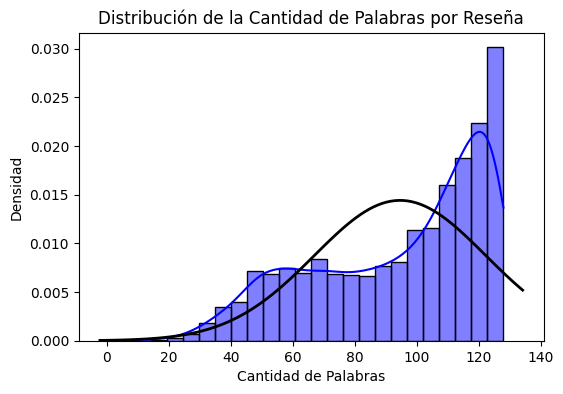

In [56]:
#Vuelvo a verificar la distribución de la longitud de reseña
# Calcular la media y el desvío estándar de la cantidad de palabras por reseña
mean_word_count = df['word_count'].mean()
std_word_count = df['word_count'].std()

# Visualizar la distribución de la cantidad de palabras por reseña
plt.figure(figsize=(6,4))
sns.histplot(df['word_count'], kde=True, stat='density', color='blue')
plt.title('Distribución de la Cantidad de Palabras por Reseña')
plt.xlabel('Cantidad de Palabras')
plt.ylabel('Densidad')
# Agregar la línea de distribución normal
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean_word_count, std_word_count)
plt.plot(x, p, 'k', linewidth=2)
plt.show()

In [57]:
# Carga del modelo BERT pre-entrenado en inglés
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

In [58]:
# Tokenización con el tokenizer de BERT en inglés
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Codificación de los tokens y creación de los conjuntos de datos de entrenamiento y prueba
max_length = 128  # longitud máxima de las secuencias de entrada
batch_size = 8

def tokenize_data(df, tokenizer, max_length):
    input_ids = []
    attention_masks = []
    labels = []

    for index, row in df.iterrows():
        encoded_dict = tokenizer.encode_plus(
                            row['cleaned_review'],
                            add_special_tokens = True,
                            max_length = max_length,
                            padding = 'max_length',
                            truncation = True,
                            return_attention_mask = True,
                            return_tensors = 'pt'
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
        labels.append(row['sentiment'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    return TensorDataset(input_ids, attention_masks, labels)


In [59]:
df_cleaned = df
df_cleaned['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

sentiment_counts = df_cleaned['sentiment'].value_counts()

print("Cantidad de sentimiento 0 (negative):", sentiment_counts[0])
print("Cantidad de sentimiento 1 (positive):", sentiment_counts[1])

Cantidad de sentimiento 0 (negative): 2500
Cantidad de sentimiento 1 (positive): 2500


In [60]:
# División de dataset en conjuntos de entrenamiento y prueba
train_df, test_df = train_test_split(df_cleaned, test_size=0.2, random_state=17, shuffle=True)

train_dataset = tokenize_data(train_df, tokenizer, max_length)
test_dataset = tokenize_data(test_df, tokenizer, max_length)

# Guardar el conjunto de datos de entrenamiento
with open('train_dataset.pkl', 'wb') as f:
    pickle.dump(train_dataset, f)

# Guardar el conjunto de datos de prueba
with open('test_dataset.pkl', 'wb') as f:
    pickle.dump(test_dataset, f)

In [61]:
# Cargar el conjunto de datos de entrenamiento
with open('train_dataset.pkl', 'rb') as f:
    train_dataset_loaded = pickle.load(f)

# Cargar el conjunto de datos de prueba
with open('test_dataset.pkl', 'rb') as f:
    test_dataset_loaded = pickle.load(f)

In [62]:
# Creación de los dataloaders
train_dataloader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size = batch_size)
test_dataloader = DataLoader(test_dataset, sampler = SequentialSampler(test_dataset), batch_size = batch_size)


# 4) Definición del modelo BERT con capas adicionales para realizar transfer learning

In [63]:
# Definición del modelo BERT pre-entrenado para clasificación de secuencias

num_labels = 2
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels= num_labels)

# Añadir capas adicionales en la salida

model.classifier = nn.Sequential(
    nn.Linear(model.config.hidden_size,8),
    nn.Tanh(),
    nn.Dropout(0.6),
    nn.Linear(8, num_labels)  # 'num_labels' es el número de clases:2
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# 5) Entrenamiento del modelo

In [64]:
# Defino los parámetros de entrenamiento
epochs = 10
learning_rate = 0.000002  # Reduzco la tasa de aprendizaje para el ajuste fino

optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

train_accuracies = []
test_accuracies = []

train_loss = []
test_loss = []

for epoch in range(epochs):
    # Modo de entrenamiento
    model.train()
    total_loss = 0

    # Entrenamiento
    for batch in train_dataloader:
        batch_input_ids = batch[0].to(device)
        batch_attention_masks = batch[1].to(device)
        batch_labels = batch[2].to(device)

        model.zero_grad()

        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    # Calcular pérdida media de entrenamiento
    avg_train_loss = total_loss / len(train_dataloader)

    # Calcular predicciones en el conjunto de entrenamiento
    train_predictions = []
    train_labels = []
    for batch in train_dataloader:
        batch_input_ids = batch[0].to(device)
        batch_attention_masks = batch[1].to(device)
        batch_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks, labels=batch_labels)
            train_predictions.extend(torch.argmax(outputs.logits, axis=1).cpu().numpy())
            train_labels.extend(batch_labels.cpu().numpy())

    # Calcular precisión en el conjunto de entrenamiento
    train_accuracy = accuracy_score(train_labels, train_predictions)



    # Modo de evaluación
    model.eval()
    total_eval_loss = 0
    eval_predictions = []
    eval_labels = []

    # Evaluación
    for batch in test_dataloader:
        batch_input_ids = batch[0].to(device)
        batch_attention_masks = batch[1].to(device)
        batch_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks, labels=batch_labels)
            loss = outputs.loss
            total_eval_loss += loss.item()
            eval_predictions.extend(torch.argmax(outputs.logits, axis=1).cpu().numpy())
            eval_labels.extend(batch_labels.cpu().numpy())

    # Calcular pérdida media de evaluación
    avg_eval_loss = total_eval_loss / len(test_dataloader)

    train_loss.append(avg_train_loss)
    test_loss.append(avg_eval_loss)

    # Calcular precisión en entrenamiento y evaluación
    test_accuracy = accuracy_score(eval_labels, eval_predictions)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print(f'Epoch {epoch + 1}/{epochs}')
    print(f'Average Training Loss: {avg_train_loss}')
    print(f'Average Evaluation Loss: {avg_eval_loss}')
    print(f'Training Accuracy: {train_accuracy}')
    print(f'Test Accuracy: {test_accuracy}')

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10
Average Training Loss: 0.5843462573885918
Average Evaluation Loss: 0.41506362187862395
Training Accuracy: 0.8285
Test Accuracy: 0.864
Epoch 2/10
Average Training Loss: 0.39775634986162184
Average Evaluation Loss: 0.33255055344104767
Training Accuracy: 0.87975
Test Accuracy: 0.897
Epoch 3/10
Average Training Loss: 0.340780208170414
Average Evaluation Loss: 0.3055216684341431
Training Accuracy: 0.903
Test Accuracy: 0.907
Epoch 4/10
Average Training Loss: 0.3158259887844324
Average Evaluation Loss: 0.31147483313083646
Training Accuracy: 0.9095
Test Accuracy: 0.905
Epoch 5/10
Average Training Loss: 0.2934647435694933
Average Evaluation Loss: 0.29557575714588163
Training Accuracy: 0.919
Test Accuracy: 0.913
Epoch 6/10
Average Training Loss: 0.2822871037721634
Average Evaluation Loss: 0.2954856621026993
Training Accuracy: 0.9265
Test Accuracy: 0.912
Epoch 7/10
Average Training Loss: 0.26169387608766553
Average Evaluation Loss: 0.29985247588157654
Training Accuracy: 0.92875
Test Ac

In [65]:
# Ruta donde guardar el modelo
ruta_modelo = '/content/drive/My Drive/Colab Notebooks/LLM/Model/model_1.pt'

# Guardar el modelo y el tokenizador
model.save_pretrained(ruta_modelo)

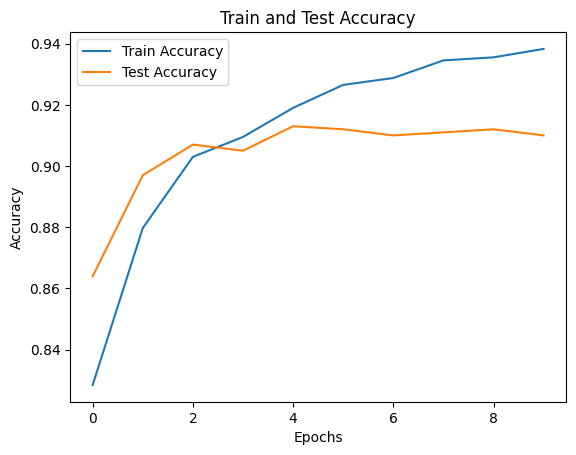

In [66]:
# Grafico precisión de entrenamiento y prueba
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Train and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


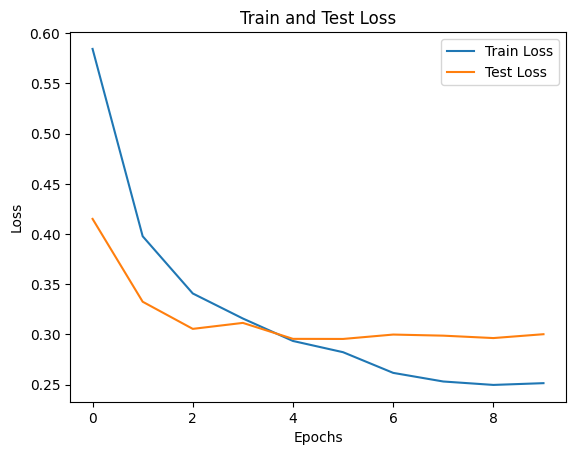

In [67]:
# Grafico pérdida promedio de entrenamiento y prueba
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.title('Train and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 6) Evaluación del modelo y resultados

In [68]:
# Evaluación del modelo
model.eval()
predictions, true_labels = [], []

for batch in test_dataloader:
    batch_input_ids = batch[0].to(device)
    batch_attention_masks = batch[1].to(device)
    batch_labels = batch[2].to('cpu').numpy()

    with torch.no_grad():
        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks)

    logits = outputs.logits.detach().cpu().numpy()
    predictions.extend(np.argmax(logits, axis=1))
    true_labels.extend(batch_labels)

accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy}')

print('Classification Report:')
print(classification_report(true_labels, predictions))

Accuracy: 0.91
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.91       479
           1       0.91      0.92      0.91       521

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



In [69]:
# Cargar el modelo y el tokenizador
ruta_modelo = '/content/drive/My Drive/Colab Notebooks/LLM'
#tokenizer = BertTokenizer.from_pretrained(ruta_modelo)
#model = BertForSequenceClassification.from_pretrained(ruta_modelo)


In [70]:

# Definir el dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Mover el modelo al dispositivo
model.to(device)

# Textos de ejemplo
text_1 = "Great movie. I would say it could be a great Oscar winner for sure this year"
text_2 =  "A total disaster. Don´t ever watch it because it’s a waste of time"
text_3 = "The movie extols moral values from another era. It's the type of film that normalizes the moral decay of the world"

textos_ejemplo = [text_1,text_2,text_3]

# Lista para almacenar las predicciones
predicciones = []

# Iterar sobre los textos de ejemplo
for texto_ejemplo in textos_ejemplo:
    # Preprocesar el texto
    tokens = tokenizer.encode_plus(
        texto_ejemplo,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    # Pasar el texto por el modelo
    input_ids = tokens['input_ids'].to(device)
    attention_mask = tokens['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    # Obtener la clase predicha
    predicted_class = torch.argmax(outputs.logits).item()

    # Mapear el índice de clase a etiquetas legibles
    if predicted_class == 0:
        clase_predicha = "negativa"
    else:
        clase_predicha = "positiva"

    # Agregar la predicción a la lista
    predicciones.append((texto_ejemplo, clase_predicha))

# Imprimir las predicciones
for texto, clase in predicciones:
    print(f"Texto: {texto}")
    print(f"Clase predicha: {clase}")
    print()

Texto: Great movie. I would say it could be a great Oscar winner for sure this year
Clase predicha: positiva

Texto: A total disaster. Don´t ever watch it because it’s a waste of time
Clase predicha: negativa

Texto: The movie extols moral values from another era. It's the type of film that normalizes the moral decay of the world
Clase predicha: positiva

